In [1]:
import torch
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_images = images.size(0)
        images = images.view(batch_images, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_images

    mean /= total_images
    std /= total_images
    return mean, std

In [24]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

dataset_for_stats = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

mean, std = calculate_mean_std(dataset_for_stats)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

val_loader = DataLoader(val_subset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
print('Train set size:', len(train_subset))
print('Validation set size:', len(val_subset))
print('Test set size:', len(test_set))

Train set size: 45000
Validation set size: 5000
Test set size: 10000


In [6]:
def get_class_counts(dataset, classes):
    counts = [0] * len(classes)
    for data, label in dataset:
        counts[label] += 1
    return counts

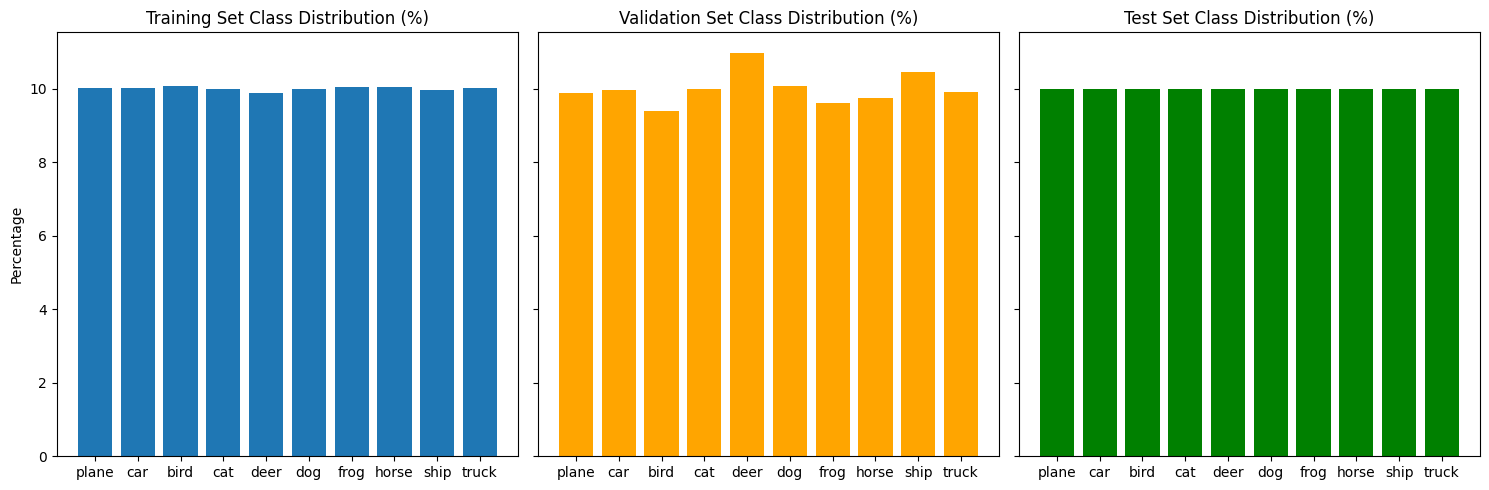

In [25]:
import matplotlib.pyplot as plt

train_counts = get_class_counts(train_subset, classes)
val_counts = get_class_counts(val_subset, classes)
test_counts = get_class_counts(test_set, classes)

train_percentages = [count / sum(train_counts) * 100 for count in train_counts]
val_percentages = [count / sum(val_counts) * 100 for count in val_counts]
test_percentages = [count / sum(test_counts) * 100 for count in test_counts]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].bar(classes, train_percentages)
ax[0].set_title("Training Set Class Distribution (%)")
ax[0].set_ylabel("Percentage")

ax[1].bar(classes, val_percentages, color='orange')
ax[1].set_title("Validation Set Class Distribution (%)")

ax[2].bar(classes, test_percentages, color='green')
ax[2].set_title("Test Set Class Distribution (%)")

plt.tight_layout()
plt.show()

In [8]:
dataiter = iter(train_loader)

Batch of images has shape: torch.Size([32, 3, 32, 32])


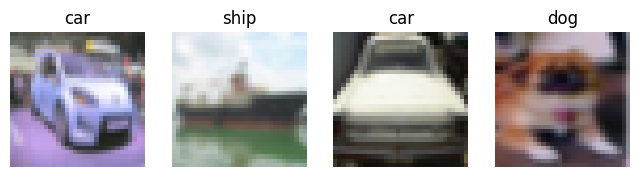

In [9]:
images, labels = next(dataiter)

print('Batch of images has shape:', images.shape)

def imshow(img, labels, num_images=4):
    img = img * std[:, None, None] + mean[:, None, None]  # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(1, num_images, figsize=(8, 2))
    for i in range(num_images):
        ax[i].imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')
    plt.show()

imshow(images, labels)

In [10]:
def images_to_patches(batch_images, patch_size):
    batch_size, channels, height, width = batch_images.shape
    assert height % patch_size == 0 and width % patch_size == 0, \
        "Wysokość i szerokość obrazu muszą być podzielne przez rozmiar patchy."
    
    patches = rearrange(batch_images, "b c (h ph) (w pw) -> b (h w) (c ph pw)", ph=patch_size, pw=patch_size)
    return patches

In [11]:
patch_size = 16
for batch_images, labels in train_loader:
    patches = images_to_patches(batch_images, patch_size)
    print("Kształt batch obrazów:", batch_images.shape)
    print("Kształt sekwencji patchy:", patches.shape)
    break # only for demonstration purposes

Kształt batch obrazów: torch.Size([32, 3, 32, 32])
Kształt sekwencji patchy: torch.Size([32, 4, 768])


In [12]:
def visualize_patches(image, patch_size):
    image_batch = image.unsqueeze(0)
    patches = images_to_patches(image_batch, patch_size)
    patches = patches[0]

    num_patches = patches.shape[0]
    grid_size = int(num_patches ** 0.5)

    image = image * std[:, None, None] + mean[:, None, None]
    patches = patches.view(num_patches, 3, patch_size, patch_size) 
    patches = [patch * std[:, None, None] + mean[:, None, None] for patch in patches]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).clip(0, 1))
    plt.title("Original image")
    plt.axis("off")
    plt.show()

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    for i, ax in enumerate(axes.flatten()):
        if i < num_patches:
            patch = patches[i]
            ax.imshow(patch.permute(1, 2, 0).clip(0, 1))
        ax.axis("off")

    plt.suptitle("Patches")
    plt.tight_layout()
    plt.show()


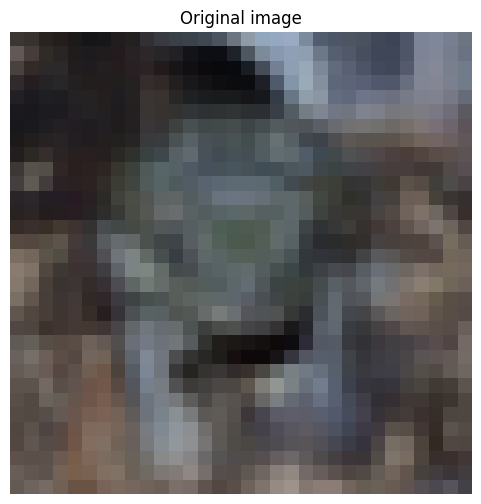

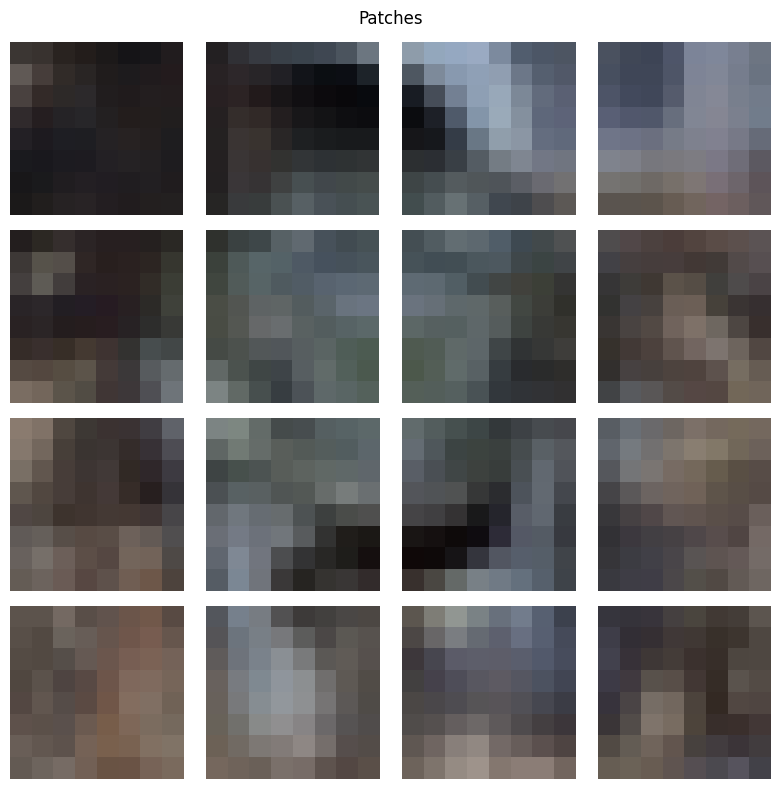

In [13]:
images, labels = next(dataiter)
image = images[0]

visualize_patches(image, patch_size=8)

In [14]:
import torch
import torch.nn as nn
from einops import rearrange

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_ratio, dropout_rate):
        super().__init__()
        # Patch Embedding
        self.patch_size = patch_size
        self.patch_dim = in_channels * patch_size * patch_size
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2

        self.embedding_layer = nn.Linear(self.patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.positional_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)

        # Transformer Encoder layers
        self.transformer_encoders = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, mlp_ratio, dropout_rate) for _ in range(depth)
        ])

        # Final layers
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = images_to_patches(x, self.patch_size)  # ciecie na patche
        x = self.embedding_layer(x)  # embedding patchy

        # Dodatkowy class token
        B, N, _ = x.shape
        # cls_token = self.cls_token.expand(B, -1, -1) 
        # x = torch.cat((cls_token, x), dim=1)

        # Positional embedding + dropout
        x = x + self.positional_embedding[:, :N, :]
        x = self.dropout(x)

        # N takich warstw
        for encoder in self.transformer_encoders:
            x = encoder(x)

        # Layer norm, class token, MLP
        x = self.layer_norm(x.mean(1))
        x = self.mlp_head(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio, dropout_rate):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout_rate),
        )

    def forward(self, x):
        norm1 = self.layer_norm1(x)
        attention, _ = self.multi_head_attention(norm1, norm1, norm1)
        x = x + attention

        norm2 = self.layer_norm2(x)
        x = x + self.mlp(norm2)
        return x

# Dla głębokości 1 bo czytelniej

In [23]:
net = VisionTransformer(img_size=32, patch_size=4, 
                        in_channels=3, num_classes=10, 
                        embed_dim=256, depth=6, 
                        num_heads=8, mlp_ratio=2, 
                        dropout_rate=0.2).to(device)

In [16]:
from torchviz import make_dot
from IPython.display import Image, display

def computational_graph(model):
    inputs = torch.randn(1, 3, 32, 32).to(device)
    outputs = model(inputs)
    target = torch.tensor([1], dtype=torch.long).to(device)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, target)
    loss.backward()
    dot = make_dot(outputs, params=dict(net.named_parameters()))
    dot.render("computation_graph", format="png")
    display(Image(filename="computation_graph.png"))

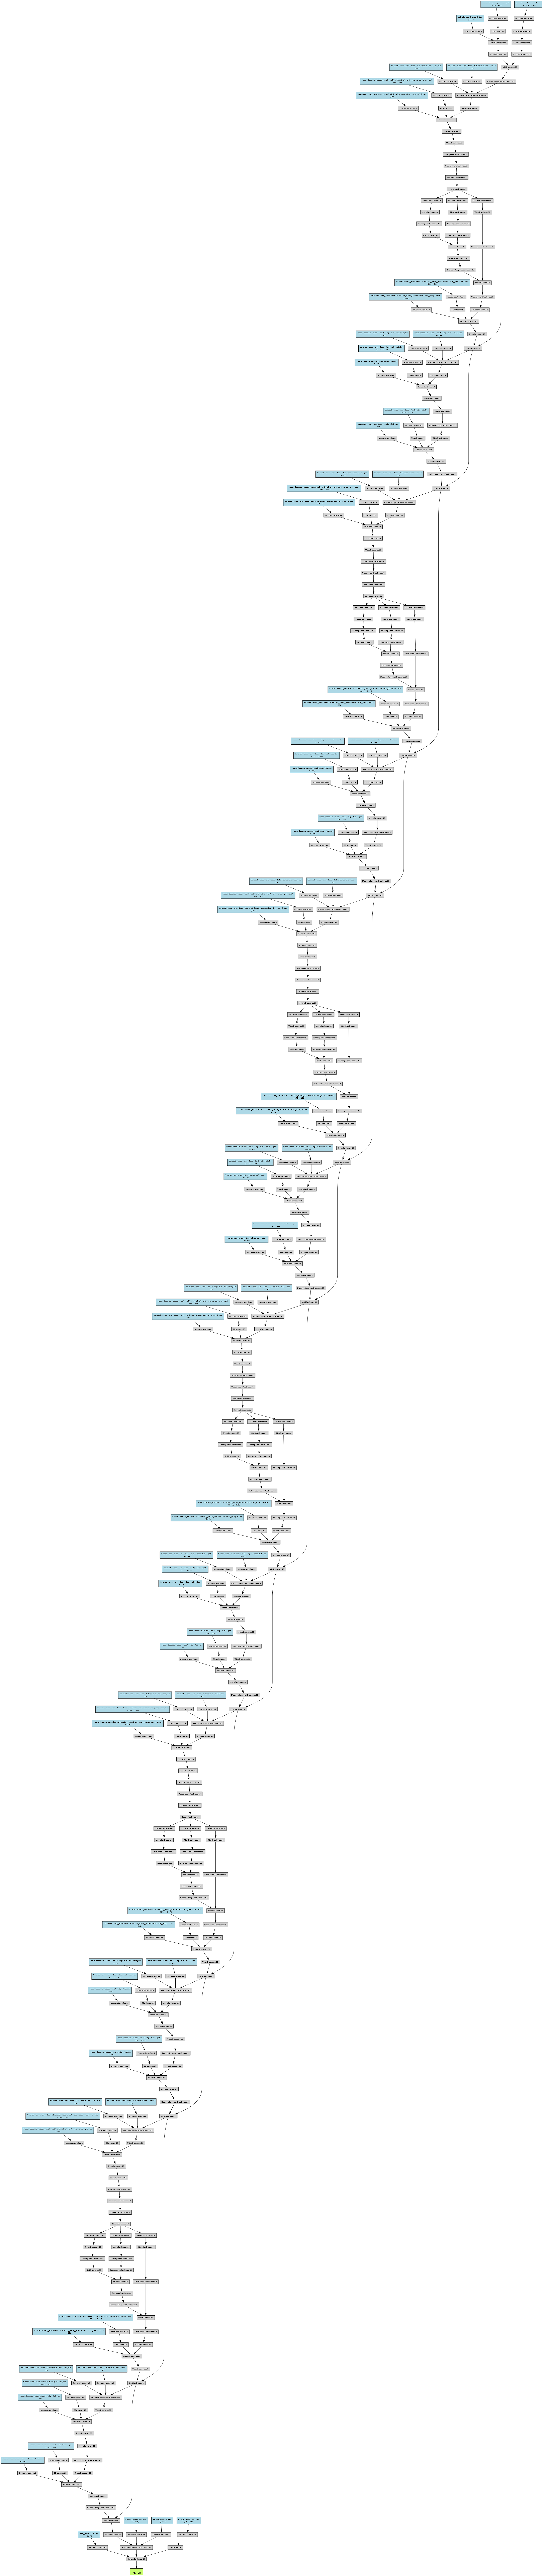

In [17]:
computational_graph(net)


(process:10488): Pango-WARNING **: 02:06:29.067: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


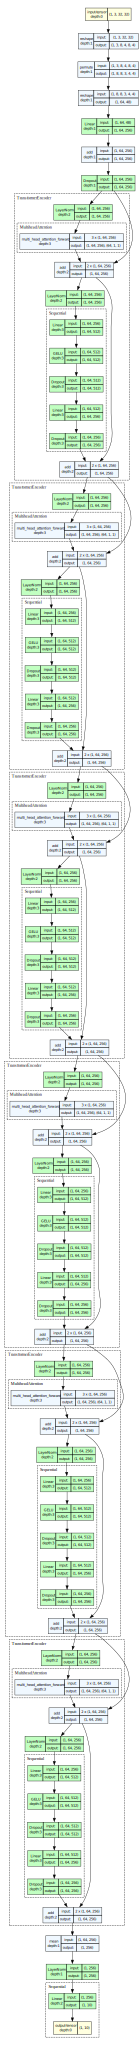

In [18]:
from torchview import draw_graph
draw_graph(net, torch.randn(1, 3, 32, 32).to(device), expand_nested=True).visual_graph

In [26]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [123]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Train Loss")
    val_epochs = list(range(0, len(train_losses), 10))
    plt.plot(val_epochs, val_losses, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss function")
    plt.legend()
    plt.grid()
    plt.show()
    
def calculate_loss(net, data_loader, criterion, device):
    net.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    net.train()
    return total_loss / len(data_loader)

def test_class_accuracy(net, data_loader, plot=False, dataset_name=""):
    net.eval()
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)
    
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    if not plot:
        for i in range(len(classes)):
            if class_total[i] > 0:
                print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
            else:
                print(f'Accuracy of {classes[i]}: N/A (no samples)')
    
    accuracy = 100 * sum(class_correct) / sum(class_total)
    print(f'Average accuracy: {accuracy:.2f}%')
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.bar(classes, [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(classes))])
        ax.set_title(f"Class Accuracy for {dataset_name}")
        ax.set_ylabel("Accuracy (%)")
        ax.grid()
        plt.show()
            
    net.train()
    
def calculate_accuracy(net, image_loader, device, df_type = "test"):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in image_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    net.train()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {df_type} images: {accuracy:.2f}%')
    return accuracy

In [27]:
train_losses = []
val_losses = []
num_epochs = 160
epoch = 0

Epoch 161, Loss: 0.8185
Epoch 162, Loss: 0.8197
Epoch 163, Loss: 0.8207
Epoch 164, Loss: 0.8175
Epoch 165, Loss: 0.8177
Epoch 166, Loss: 0.8193
Epoch 167, Loss: 0.8166
Epoch 168, Loss: 0.8131
Epoch 169, Loss: 0.8215
Epoch 170, Loss: 0.8221
Accuracy of plane: 78.74%
Accuracy of car: 80.32%
Accuracy of bird: 54.68%
Accuracy of cat: 45.80%
Accuracy of deer: 60.66%
Accuracy of dog: 56.15%
Accuracy of frog: 79.21%
Accuracy of horse: 69.20%
Accuracy of ship: 77.39%
Accuracy of truck: 75.96%
Average accuracy: 67.78%


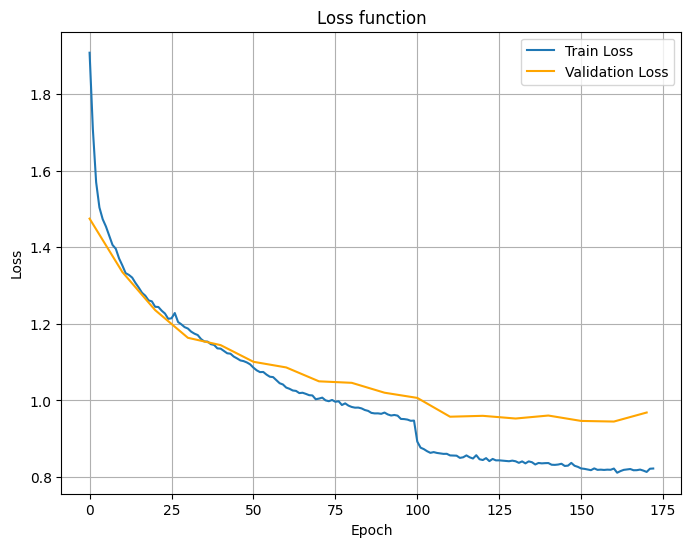

Epoch 171, Loss: 0.8161
Epoch 172, Loss: 0.8216
Epoch 173, Loss: 0.8188
Epoch 174, Loss: 0.8200
Epoch 175, Loss: 0.8178
Epoch 176, Loss: 0.8251
Epoch 177, Loss: 0.8176
Epoch 178, Loss: 0.8149
Epoch 179, Loss: 0.8182
Epoch 180, Loss: 0.8163
Accuracy of plane: 77.13%
Accuracy of car: 80.92%
Accuracy of bird: 53.83%
Accuracy of cat: 47.80%
Accuracy of deer: 60.66%
Accuracy of dog: 56.35%
Accuracy of frog: 76.72%
Accuracy of horse: 67.76%
Accuracy of ship: 76.82%
Accuracy of truck: 77.78%
Average accuracy: 67.56%


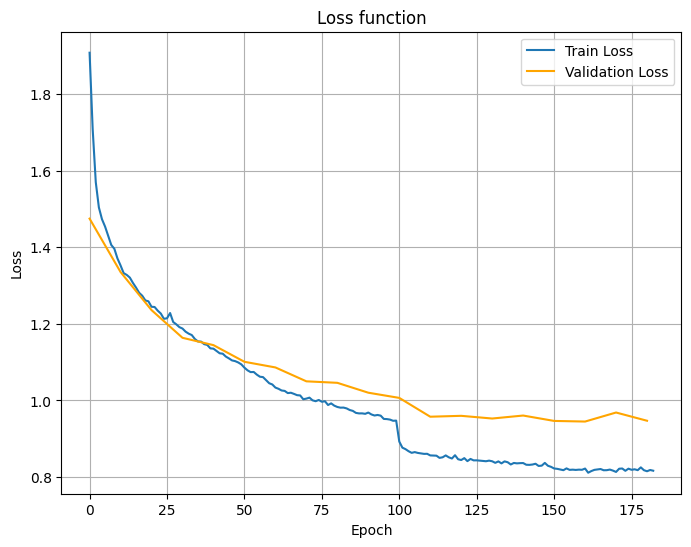

Epoch 181, Loss: 0.8206
Epoch 182, Loss: 0.8193
Epoch 183, Loss: 0.8173
Epoch 184, Loss: 0.8175
Epoch 185, Loss: 0.8184
Epoch 186, Loss: 0.8145
Epoch 187, Loss: 0.8163
Epoch 188, Loss: 0.8160
Epoch 189, Loss: 0.8133
Epoch 190, Loss: 0.8130
Accuracy of plane: 76.11%
Accuracy of car: 79.32%
Accuracy of bird: 54.26%
Accuracy of cat: 45.00%
Accuracy of deer: 60.47%
Accuracy of dog: 56.15%
Accuracy of frog: 77.96%
Accuracy of horse: 66.32%
Accuracy of ship: 77.39%
Accuracy of truck: 78.38%
Average accuracy: 67.12%


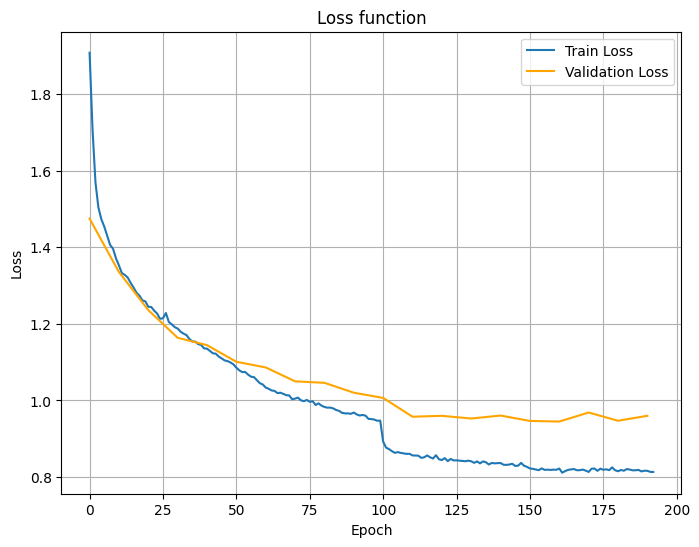

Epoch 191, Loss: 0.8197
Epoch 192, Loss: 0.8112
Epoch 193, Loss: 0.8182
Epoch 194, Loss: 0.8162
Epoch 195, Loss: 0.8132
Epoch 196, Loss: 0.8184
Epoch 197, Loss: 0.8142
Epoch 198, Loss: 0.8197
Epoch 199, Loss: 0.8164
Epoch 200, Loss: 0.8160
Accuracy of plane: 76.32%
Accuracy of car: 78.71%
Accuracy of bird: 54.47%
Accuracy of cat: 49.40%
Accuracy of deer: 59.74%
Accuracy of dog: 55.36%
Accuracy of frog: 80.87%
Accuracy of horse: 70.02%
Accuracy of ship: 77.97%
Accuracy of truck: 77.58%
Average accuracy: 68.00%


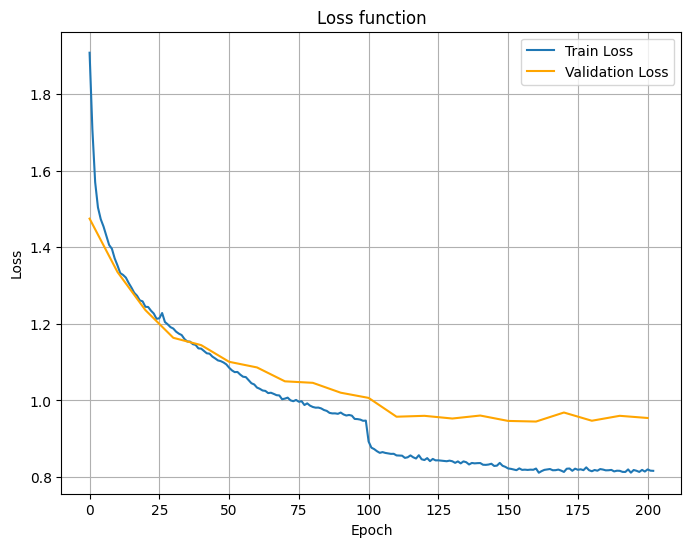

Epoch 201, Loss: 0.8194
Epoch 202, Loss: 0.8187
Epoch 203, Loss: 0.8164
Epoch 204, Loss: 0.8140
Epoch 205, Loss: 0.8149
Epoch 206, Loss: 0.8169
Epoch 207, Loss: 0.8179
Epoch 208, Loss: 0.8160
Epoch 209, Loss: 0.8132
Epoch 210, Loss: 0.8176
Accuracy of plane: 77.13%
Accuracy of car: 79.32%
Accuracy of bird: 54.04%
Accuracy of cat: 49.00%
Accuracy of deer: 62.48%
Accuracy of dog: 56.15%
Accuracy of frog: 78.38%
Accuracy of horse: 67.56%
Accuracy of ship: 76.63%
Accuracy of truck: 77.78%
Average accuracy: 67.84%


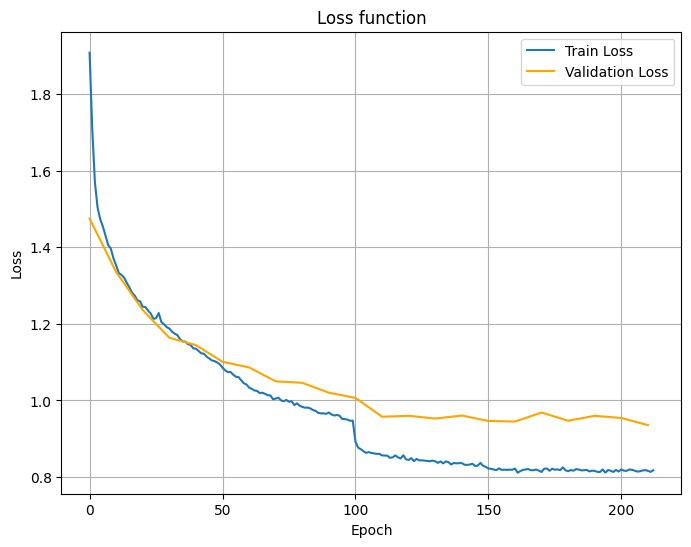

Epoch 211, Loss: 0.8157
Epoch 212, Loss: 0.8160
Epoch 213, Loss: 0.8163
Epoch 214, Loss: 0.8143
Epoch 215, Loss: 0.8187
Epoch 216, Loss: 0.8168
Epoch 217, Loss: 0.8140
Epoch 218, Loss: 0.8180
Epoch 219, Loss: 0.8123
Epoch 220, Loss: 0.8117
Accuracy of plane: 74.09%
Accuracy of car: 80.92%
Accuracy of bird: 54.47%
Accuracy of cat: 51.80%
Accuracy of deer: 62.84%
Accuracy of dog: 56.35%
Accuracy of frog: 79.42%
Accuracy of horse: 67.76%
Accuracy of ship: 78.54%
Accuracy of truck: 76.57%
Average accuracy: 68.28%


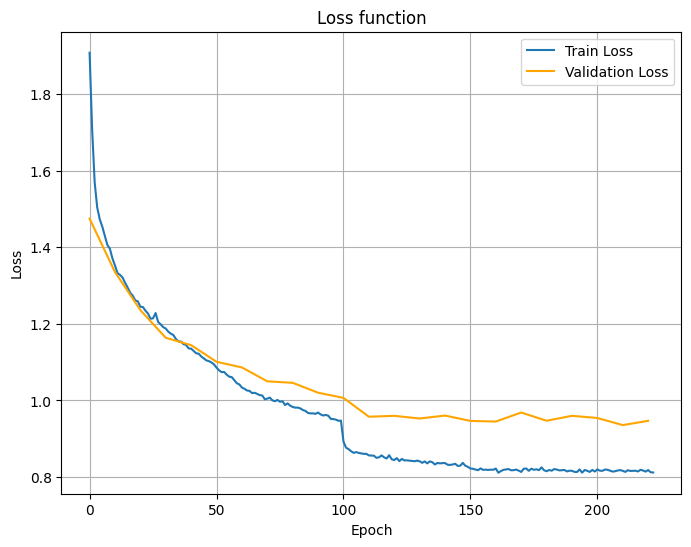

Epoch 221, Loss: 0.8138
Epoch 222, Loss: 0.8171
Epoch 223, Loss: 0.8147
Epoch 224, Loss: 0.8181
Epoch 225, Loss: 0.8129
Epoch 226, Loss: 0.8169
Epoch 227, Loss: 0.8177
Epoch 228, Loss: 0.8108
Epoch 229, Loss: 0.8109
Epoch 230, Loss: 0.8130
Accuracy of plane: 75.51%
Accuracy of car: 80.72%
Accuracy of bird: 55.32%
Accuracy of cat: 47.80%
Accuracy of deer: 60.11%
Accuracy of dog: 55.36%
Accuracy of frog: 78.38%
Accuracy of horse: 70.43%
Accuracy of ship: 80.84%
Accuracy of truck: 75.76%
Average accuracy: 68.00%


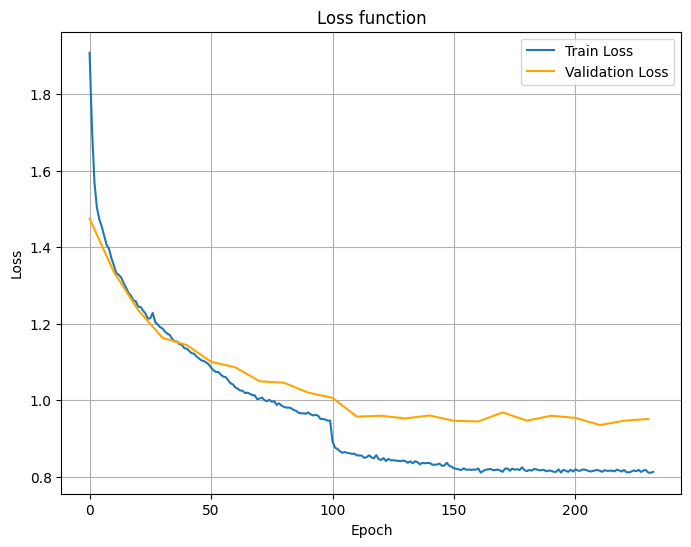

Epoch 231, Loss: 0.8108
Epoch 232, Loss: 0.8114
Epoch 233, Loss: 0.8119
Epoch 234, Loss: 0.8142
Epoch 235, Loss: 0.8127
Epoch 236, Loss: 0.8129
Epoch 237, Loss: 0.8086
Epoch 238, Loss: 0.8059
Epoch 239, Loss: 0.8088
Epoch 240, Loss: 0.8155
Accuracy of plane: 73.89%
Accuracy of car: 78.71%
Accuracy of bird: 54.26%
Accuracy of cat: 50.60%
Accuracy of deer: 60.47%
Accuracy of dog: 56.35%
Accuracy of frog: 77.34%
Accuracy of horse: 67.35%
Accuracy of ship: 78.54%
Accuracy of truck: 78.99%
Average accuracy: 67.64%


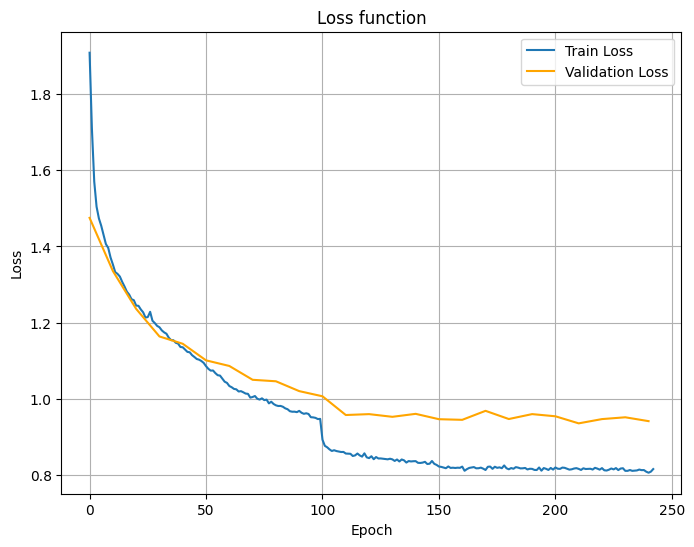

Epoch 241, Loss: 0.8137
Epoch 242, Loss: 0.8121
Epoch 243, Loss: 0.8127
Epoch 244, Loss: 0.8128
Epoch 245, Loss: 0.8058
Epoch 246, Loss: 0.8125
Epoch 247, Loss: 0.8123
Epoch 248, Loss: 0.8122
Epoch 249, Loss: 0.8143
Epoch 250, Loss: 0.8139
Accuracy of plane: 77.94%
Accuracy of car: 82.13%
Accuracy of bird: 54.47%
Accuracy of cat: 48.20%
Accuracy of deer: 61.57%
Accuracy of dog: 57.34%
Accuracy of frog: 77.55%
Accuracy of horse: 66.12%
Accuracy of ship: 78.16%
Accuracy of truck: 78.99%
Average accuracy: 68.24%


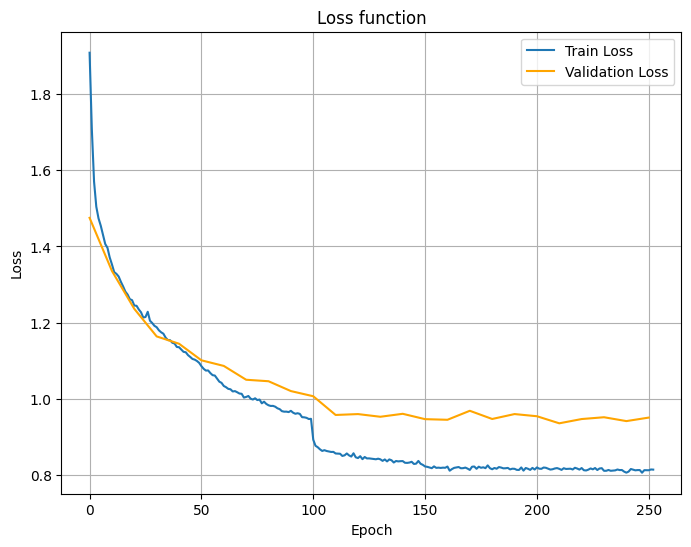

Epoch 251, Loss: 0.8127
Epoch 252, Loss: 0.8133
Epoch 253, Loss: 0.8130
Epoch 254, Loss: 0.8127
Epoch 255, Loss: 0.8100
Epoch 256, Loss: 0.8119
Epoch 257, Loss: 0.8108
Epoch 258, Loss: 0.8114
Epoch 259, Loss: 0.8122
Epoch 260, Loss: 0.8084
Accuracy of plane: 75.91%
Accuracy of car: 78.92%
Accuracy of bird: 55.53%
Accuracy of cat: 49.00%
Accuracy of deer: 62.66%
Accuracy of dog: 55.95%
Accuracy of frog: 78.79%
Accuracy of horse: 68.99%
Accuracy of ship: 75.10%
Accuracy of truck: 78.38%
Average accuracy: 67.90%


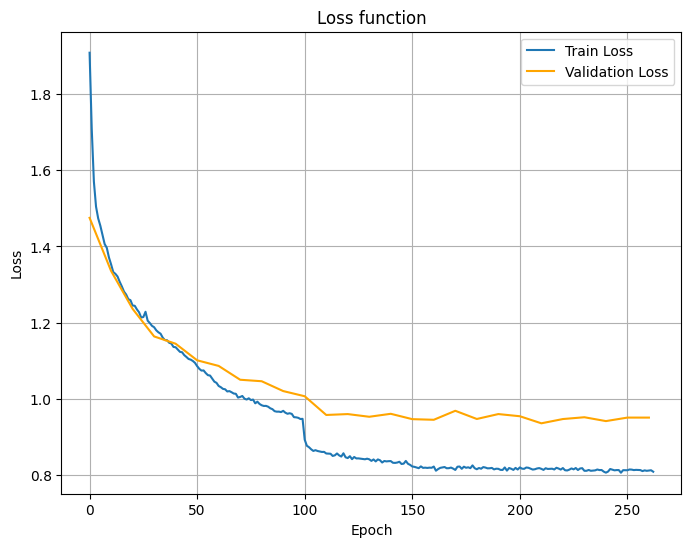

Epoch 261, Loss: 0.8082
Epoch 262, Loss: 0.8164
Epoch 263, Loss: 0.8158
Epoch 264, Loss: 0.8110
Epoch 265, Loss: 0.8132
Epoch 266, Loss: 0.8152
Epoch 267, Loss: 0.8086
Epoch 268, Loss: 0.8120
Epoch 269, Loss: 0.8106
Epoch 270, Loss: 0.8119
Accuracy of plane: 76.72%
Accuracy of car: 79.92%
Accuracy of bird: 53.83%
Accuracy of cat: 46.20%
Accuracy of deer: 60.66%
Accuracy of dog: 56.75%
Accuracy of frog: 78.17%
Accuracy of horse: 67.76%
Accuracy of ship: 76.25%
Accuracy of truck: 78.59%
Average accuracy: 67.46%


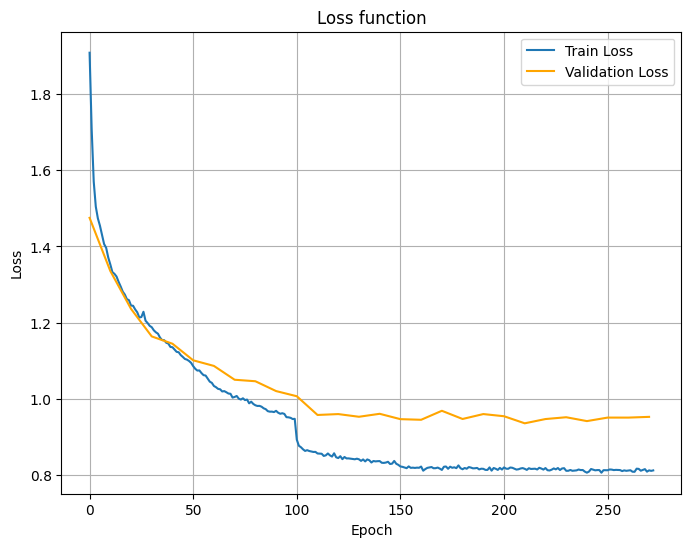

Epoch 271, Loss: 0.8086
Epoch 272, Loss: 0.8090
Epoch 273, Loss: 0.8128
Epoch 274, Loss: 0.8136
Epoch 275, Loss: 0.8109
Epoch 276, Loss: 0.8139
Epoch 277, Loss: 0.8107
Epoch 278, Loss: 0.8080
Epoch 279, Loss: 0.8118
Epoch 280, Loss: 0.8102
Accuracy of plane: 73.68%
Accuracy of car: 79.92%
Accuracy of bird: 52.55%
Accuracy of cat: 49.40%
Accuracy of deer: 61.93%
Accuracy of dog: 55.75%
Accuracy of frog: 77.55%
Accuracy of horse: 67.76%
Accuracy of ship: 78.16%
Accuracy of truck: 78.38%
Average accuracy: 67.52%


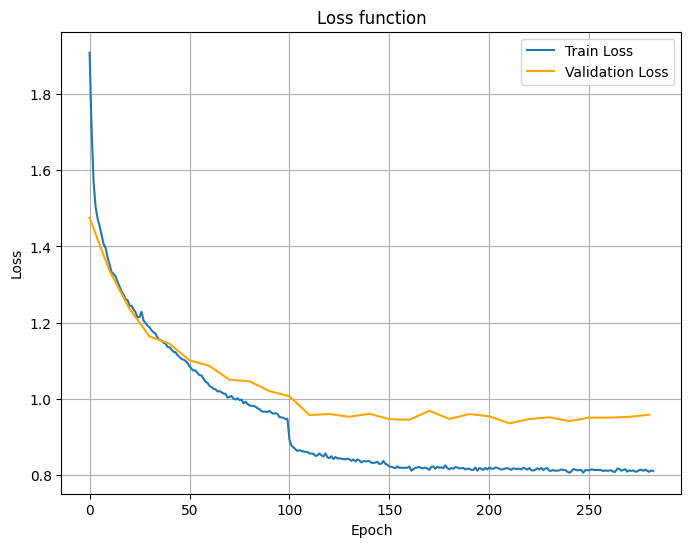

Epoch 281, Loss: 0.8081
Epoch 282, Loss: 0.8125
Epoch 283, Loss: 0.8130
Epoch 284, Loss: 0.8087
Epoch 285, Loss: 0.8125
Epoch 286, Loss: 0.8074
Epoch 287, Loss: 0.8083
Epoch 288, Loss: 0.8106
Epoch 289, Loss: 0.8086
Epoch 290, Loss: 0.8066
Accuracy of plane: 77.53%
Accuracy of car: 79.52%
Accuracy of bird: 55.74%
Accuracy of cat: 47.20%
Accuracy of deer: 61.75%
Accuracy of dog: 55.75%
Accuracy of frog: 78.38%
Accuracy of horse: 68.17%
Accuracy of ship: 77.97%
Accuracy of truck: 76.57%
Average accuracy: 67.84%


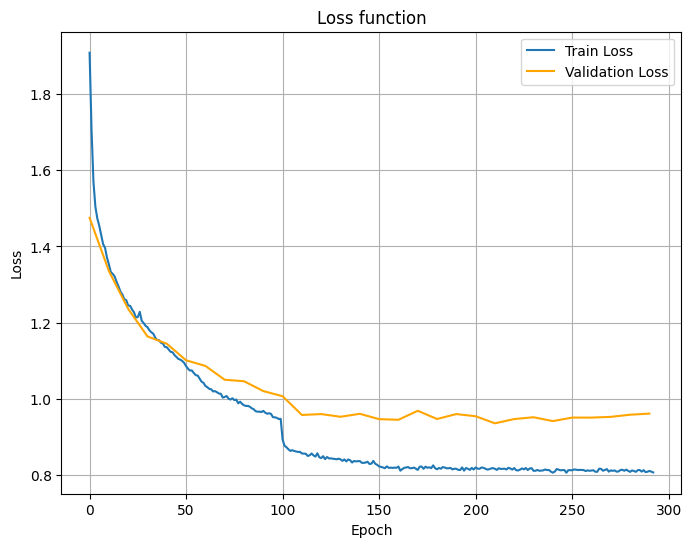

Epoch 291, Loss: 0.8094
Epoch 292, Loss: 0.8113
Epoch 293, Loss: 0.8082
Epoch 294, Loss: 0.8096
Epoch 295, Loss: 0.8095
Epoch 296, Loss: 0.8107
Epoch 297, Loss: 0.8102
Epoch 298, Loss: 0.8097
Epoch 299, Loss: 0.8064
Epoch 300, Loss: 0.8098
Accuracy of plane: 75.71%
Accuracy of car: 78.92%
Accuracy of bird: 54.47%
Accuracy of cat: 47.60%
Accuracy of deer: 59.93%
Accuracy of dog: 55.56%
Accuracy of frog: 79.21%
Accuracy of horse: 68.38%
Accuracy of ship: 78.54%
Accuracy of truck: 78.18%
Average accuracy: 67.62%


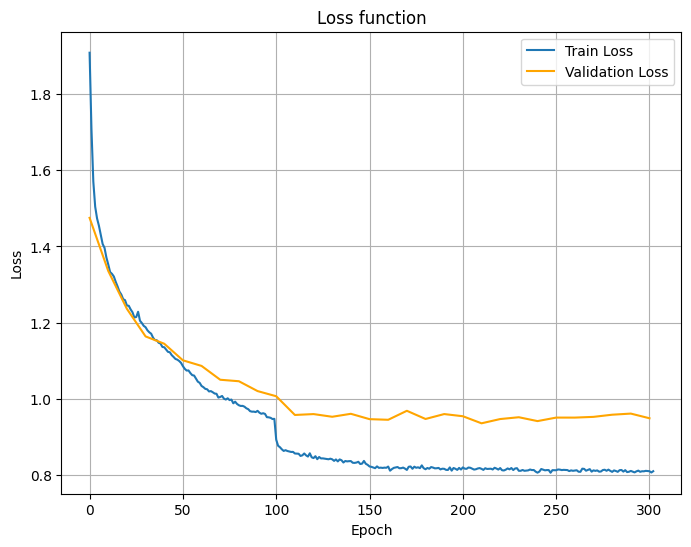

Epoch 301, Loss: 0.8106
Epoch 302, Loss: 0.8118
Epoch 303, Loss: 0.8076
Epoch 304, Loss: 0.8054
Epoch 305, Loss: 0.8123
Epoch 306, Loss: 0.8059
Epoch 307, Loss: 0.8083
Epoch 308, Loss: 0.8074
Epoch 309, Loss: 0.8091
Epoch 310, Loss: 0.8094
Accuracy of plane: 75.30%
Accuracy of car: 78.51%
Accuracy of bird: 51.70%
Accuracy of cat: 46.80%
Accuracy of deer: 62.84%
Accuracy of dog: 55.56%
Accuracy of frog: 79.83%
Accuracy of horse: 68.17%
Accuracy of ship: 77.97%
Accuracy of truck: 77.58%
Average accuracy: 67.44%


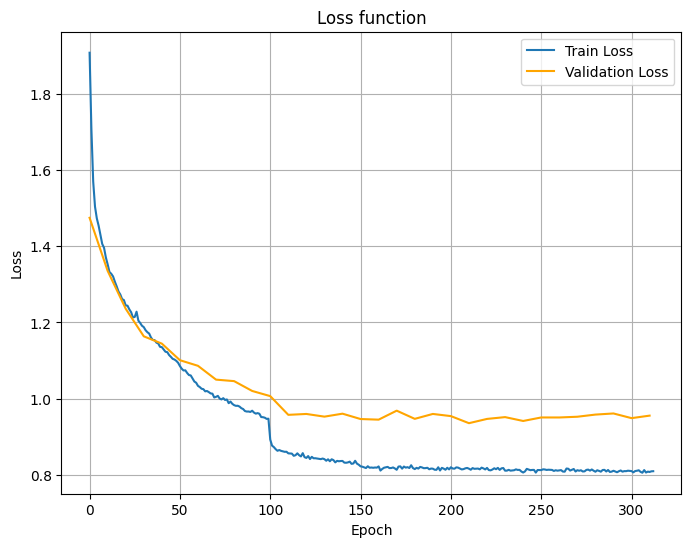

Epoch 311, Loss: 0.8087
Epoch 312, Loss: 0.8066
Epoch 313, Loss: 0.8083
Epoch 314, Loss: 0.8110
Epoch 315, Loss: 0.8074
Epoch 316, Loss: 0.8066
Epoch 317, Loss: 0.8078
Epoch 318, Loss: 0.8050
Epoch 319, Loss: 0.8096
Epoch 320, Loss: 0.8095
Accuracy of plane: 75.91%
Accuracy of car: 78.51%
Accuracy of bird: 57.02%
Accuracy of cat: 48.40%
Accuracy of deer: 60.84%
Accuracy of dog: 55.16%
Accuracy of frog: 76.72%
Accuracy of horse: 67.15%
Accuracy of ship: 77.78%
Accuracy of truck: 76.97%
Average accuracy: 67.42%


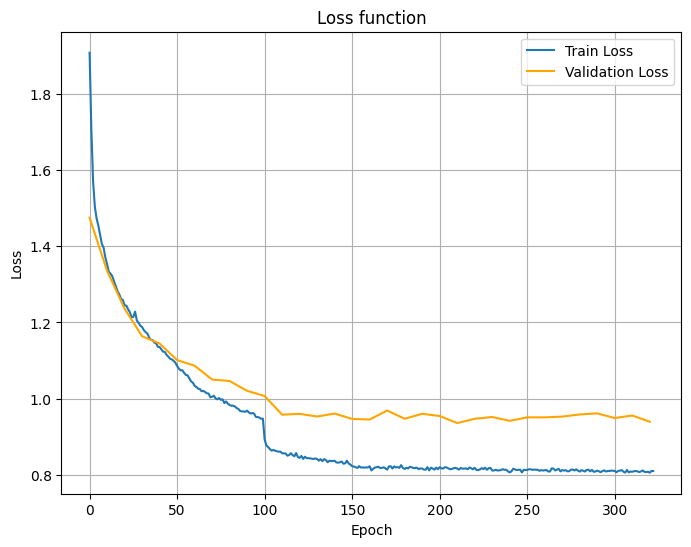

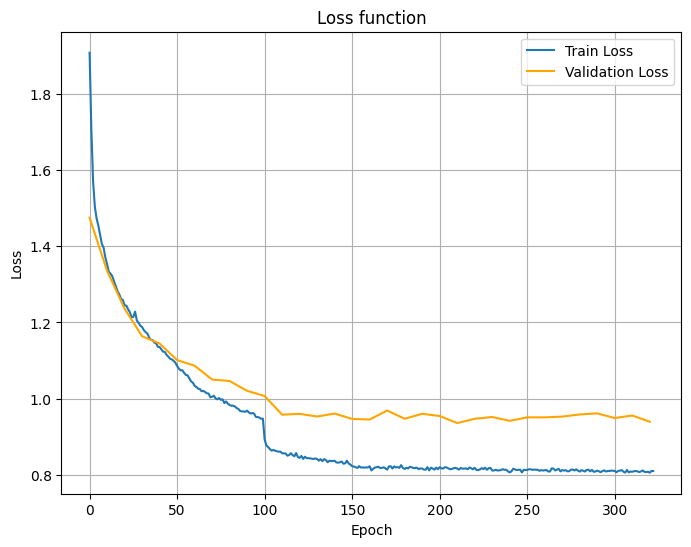

In [125]:
for epoch in range(epoch, num_epochs + epoch):
    net.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    
    if epoch % 10 == 9:
        val_loss = calculate_loss(net, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        test_class_accuracy(net, val_loader)
    
        plot_loss(train_losses, val_losses)
        
        
plot_loss(train_losses, val_losses)

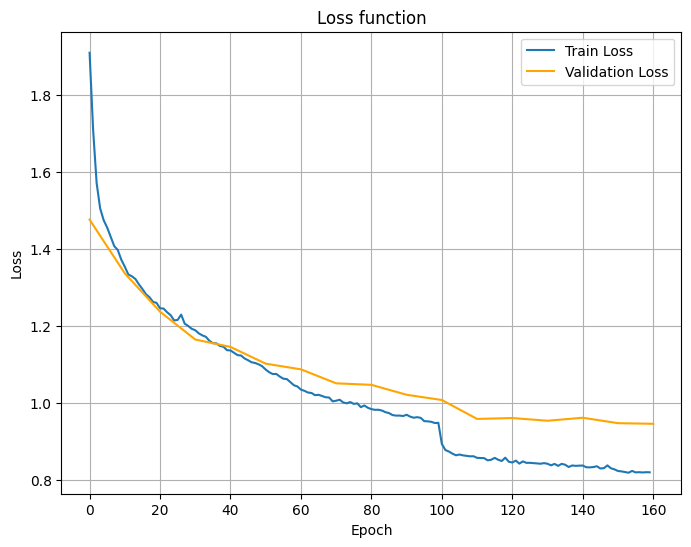

In [108]:
plot_loss(train_losses, val_losses)

In [42]:
calculate_accuracy(net, train_loader, device, "train")
calculate_accuracy(net, val_loader, device, "validation")
calculate_accuracy(net, test_loader, device, "test")

Accuracy of the network on the train images: 72.52%
Accuracy of the network on the validation images: 67.20%
Accuracy of the network on the test images: 67.28%


67.28

Average accuracy: 72.60%


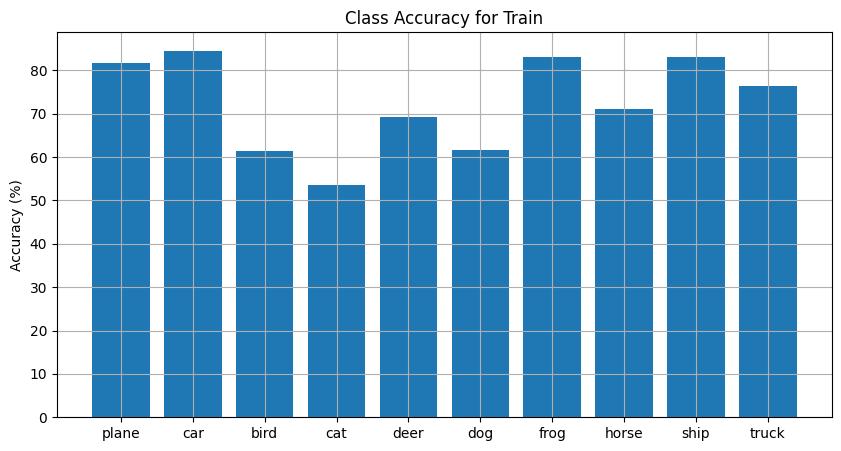

Average accuracy: 67.70%


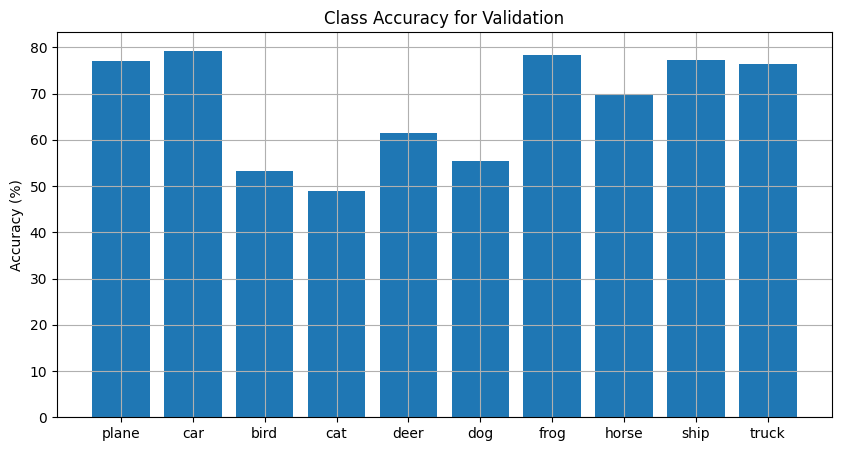

Average accuracy: 67.75%


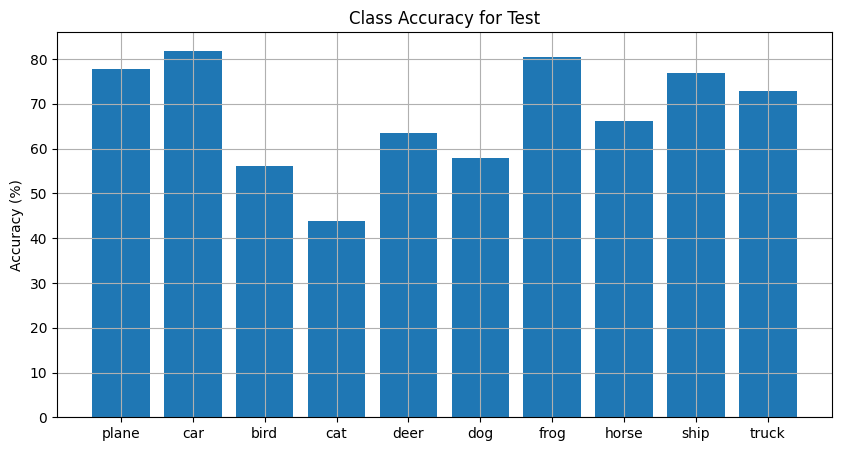

In [47]:
test_class_accuracy(net, train_loader, plot=True, dataset_name="Train")
test_class_accuracy(net, val_loader, plot=True, dataset_name="Validation")
test_class_accuracy(net, test_loader, plot=True, dataset_name="Test")

Average accuracy: 72.92%


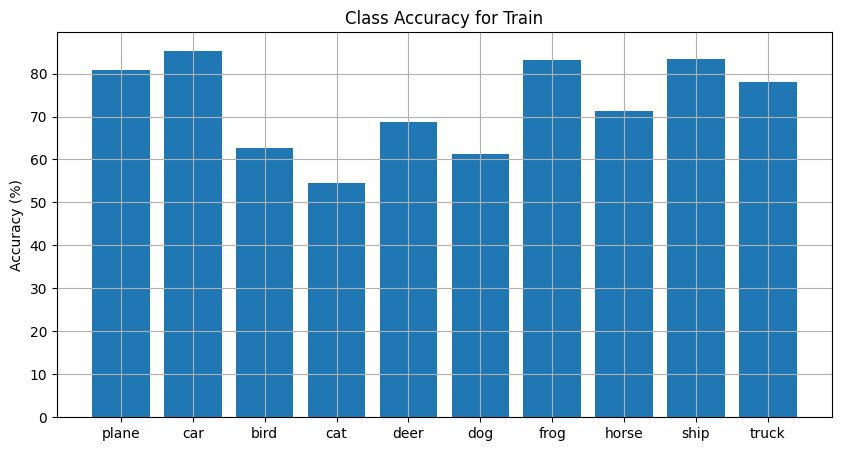

Average accuracy: 67.70%


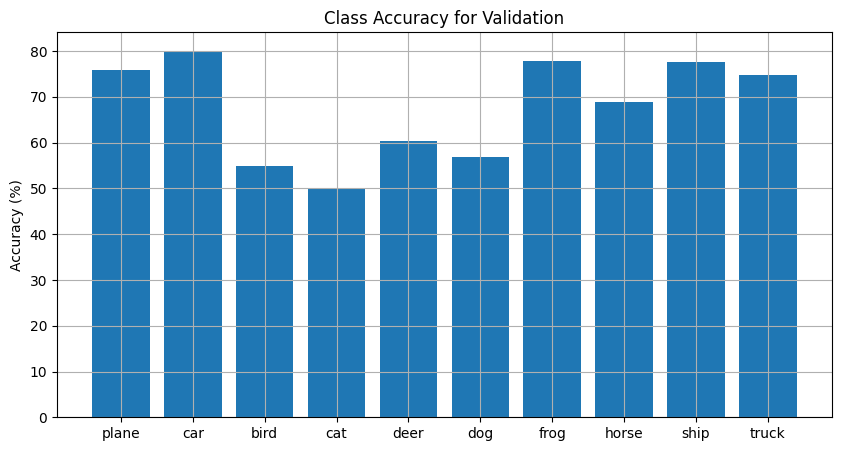

Average accuracy: 67.26%


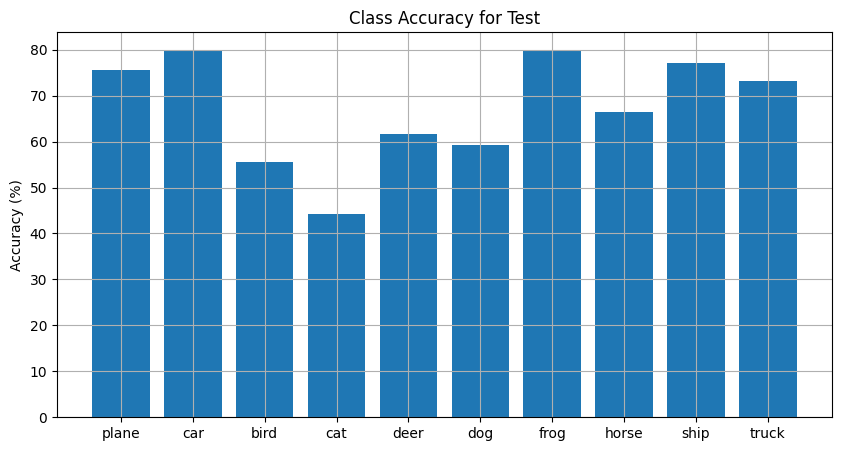

In [142]:
# po milionach lat treningu
test_class_accuracy(net, train_loader, plot=True, dataset_name="Train")
test_class_accuracy(net, val_loader, plot=True, dataset_name="Validation")
test_class_accuracy(net, test_loader, plot=True, dataset_name="Test")

In [36]:
test_dataiter = iter(test_loader)

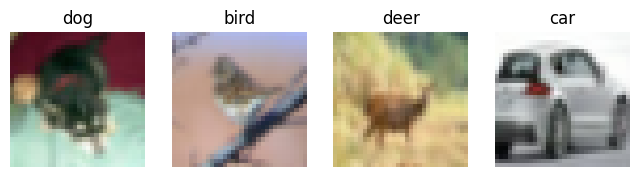

GroundTruth: dog bird deer car
Predicted: cat plane deer truck


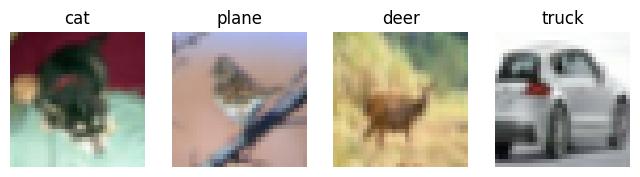

In [39]:
images, labels = next(test_dataiter)

imshow(images, labels)
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

images, labels = images.to(device), labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

imshow(images.cpu(), predicted)

In [96]:
from PIL import Image

def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(image)
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {classes[predicted[0]]}')
    net.train()

    image = image.squeeze(0).cpu() 
    image = image * std[:, None, None] + mean[:, None, None] 
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image.clip(0, 1))
    plt.title(f'Predicted: {classes[predicted[0]]}')
    plt.axis('off')
    plt.show()

In [ ]:
predict_image("glupi_kot.jpg")

Predicted: bird


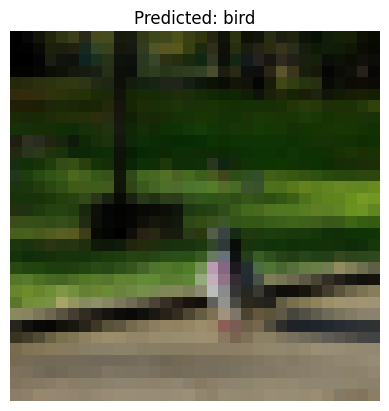

In [140]:
predict_image("mewa.jpg")